## 1. Import all important documents.
This project uses the tensorflow keras framework 

In [2]:
!pip install -U tensorflow-addons
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive') 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Galaxy 10 dataset


Dataset is loaded via **astroNN**, a python library for astronomy research.

In [3]:
!pip install -U astroNN
from astroNN.datasets import galaxy10
from tensorflow.keras.utils import to_categorical
images, labels = galaxy10.load_data()
labels = to_categorical(labels, 10)
#load images and labels as numpy arrays
labels = labels.astype(np.float32)
images = images.astype(np.float32)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.3 MB 4.9 MB/s 
     |████████████████████████████████| 4.5 MB 40.1 MB/s 
     |████████████████████████████████| 832 kB 54.6 MB/s 
     |████████████████████████████████| 48 kB 5.9 MB/s 
     |████████████████████████████████| 4.0 MB 30.4 MB/s 
  Created wheel for astroNN: filename=astroNN-1.0.1-py3-none-any.whl size=9284595 sha256=c2190c8cc3698145606cba8460f941d19fcb7623bc409910eba6f446aeceb193
  Stored in directory: /root/.cache/pip/wheels/26/a4/7e/4cbf2a7f9cd51929da9d09345e8cd37c647b54825a1314dd2d
Successfully built astroNN
WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


Galaxy10.h5:  98%|█████████▊| 205M/210M [00:02<00:00, 116MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10.h5


Galaxy10.h5: 210MB [00:02, 70.4MB/s]                          


## Preprocess the data 

In [17]:
#Split the dataset into train and test 
#with 20% being the test dataset and 80% being the train dataset
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.2)
x_train, y_train, x_test, y_test = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]
# the labels here are in one-hot encoding format therefore we need to convert them to actual classes using np.nonzero
y_train = np.nonzero(y_train)[1]
y_test = np.nonzero(y_test)[1]
# add additional dimension to the y axis
y_train = np.expand_dims(y_train, axis = 1)
y_test = np.expand_dims(y_test, axis = 1)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
#double check the shape of the labels are correct 
print(y_train.shape)
print(y_test.shape)

x_train shape: (17428, 69, 69, 3) - y_train shape: (17428, 1)
x_test shape: (4357, 69, 69, 3) - y_test shape: (4357, 1)
(17428, 1)
(4357, 1)


Take a look at some of the images in our training data!

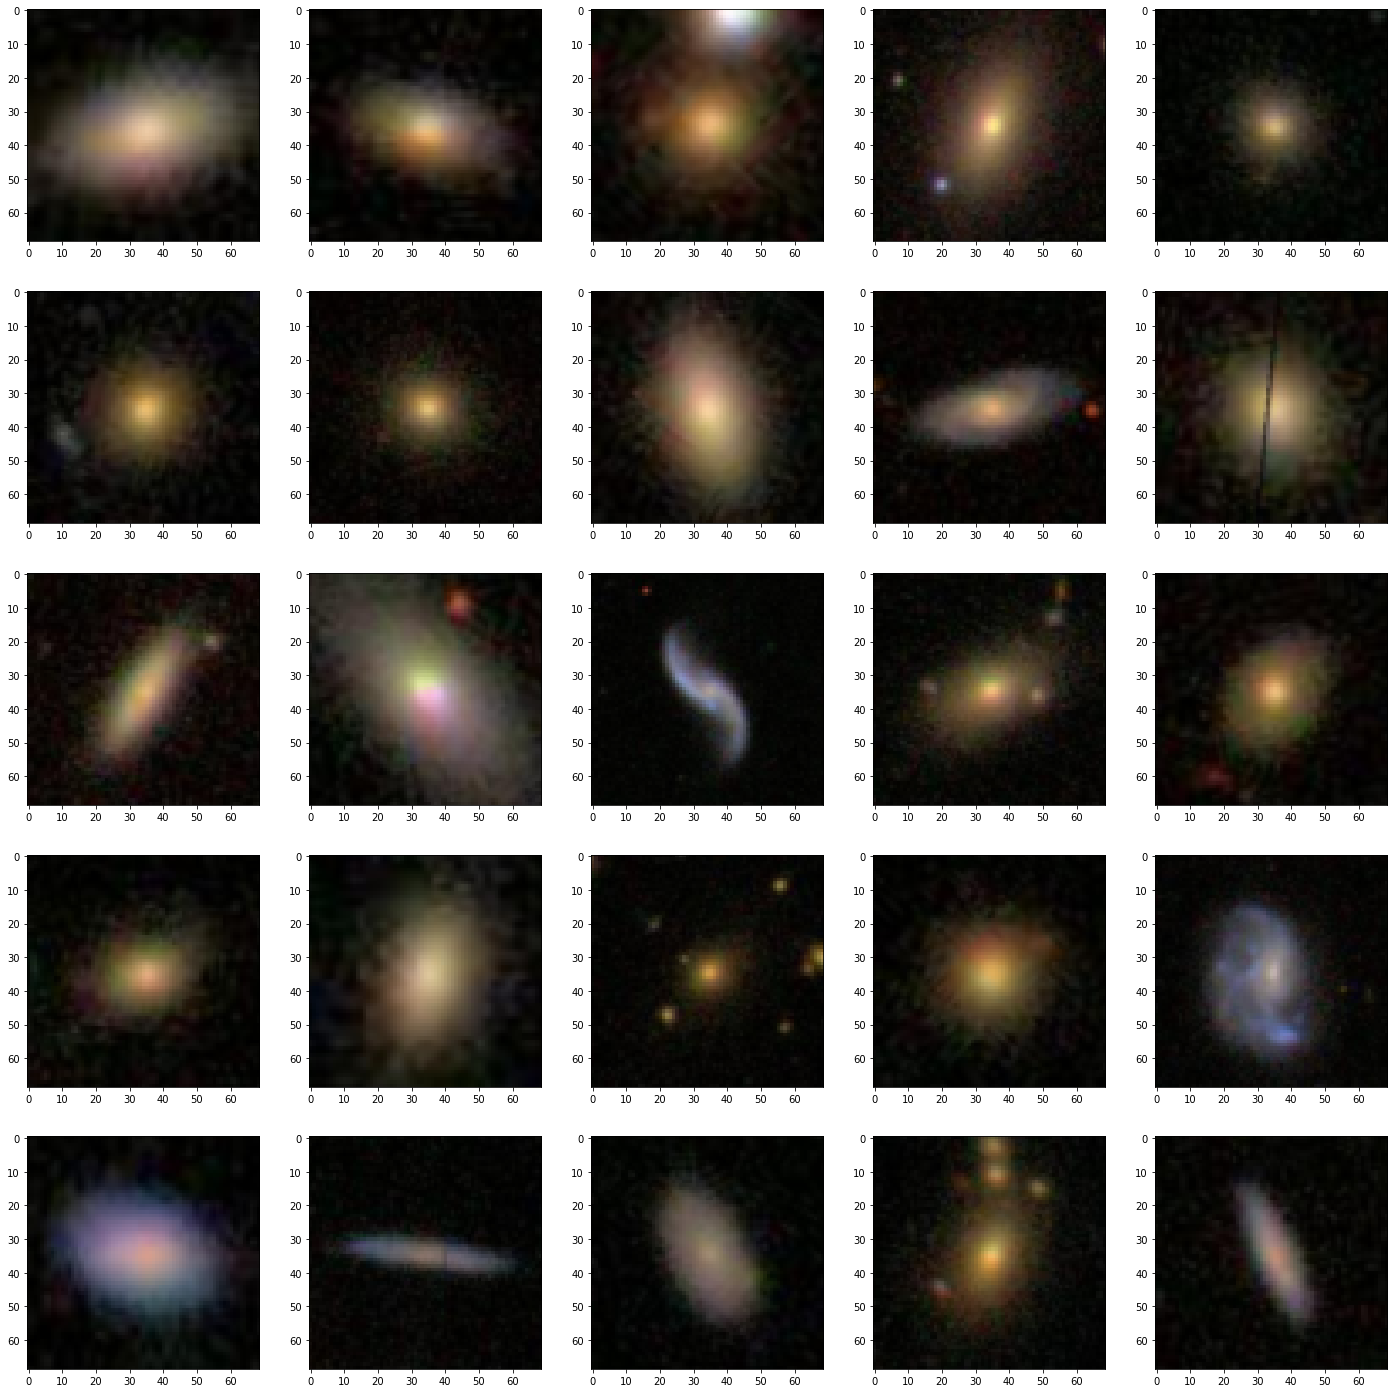

In [18]:
x_train_copy = x_train / 255.0

fig = plt.figure(figsize=(20,20)) 

for i in range(25):
    plt.subplot(5,5,i+1)    
    plt.imshow(x_train_copy[i])
    fig.tight_layout(pad=3.0)
    
plt.show()


In [27]:
num_classes = 10
input_shape = (69, 69, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 20
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]

In order to make the model more robust to unseen images, we perform data augmentation including normalization, random flip, random rotation, and random zoom!

In [28]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

This is the MLP heads that is used for classification at the end of the model. We used two layers of MLP which have 2048 and 1024 hidden units respectively.

In [29]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

We create the patches as if they are layers (inherit from the layer class)

In [30]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

## Display Patches for Sample Image!

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


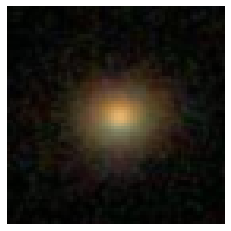

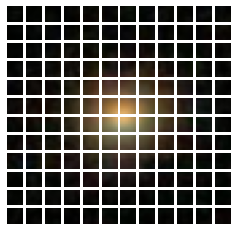

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

After we have the patches, we will perform 3 steps: 1. flatten the patches into 1 dimensional 2. do a linear projection of these flattened patches 3. add positional encoding (note these positional encodings are also learnt during the training process)

In [32]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Finally we put it altogether to form the Vision transformer

In [33]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# Perform training and obtain some results! 

In [34]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/20
62/62 [==============================] - 36s 411ms/step - loss: 2.8291 - accuracy: 0.3091 - top-5-accuracy: 0.8715 - val_loss: 1.3630 - val_accuracy: 0.4532 - val_top-5-accuracy: 0.9570
Epoch 2/20
62/62 [==============================] - 24s 394ms/step - loss: 1.4241 - accuracy: 0.4187 - top-5-accuracy: 0.9518 - val_loss: 1.1704 - val_accuracy: 0.5376 - val_top-5-accuracy: 0.9776
Epoch 3/20
62/62 [==============================] - 25s 404ms/step - loss: 1.3090 - accuracy: 0.4900 - top-5-accuracy: 0.9597 - val_loss: 1.1086 - val_accuracy: 0.5823 - val_top-5-accuracy: 0.9759
Epoch 4/20
62/62 [==============================] - 25s 400ms/step - loss: 1.2472 - accuracy: 0.5257 - top-5-accuracy: 0.9631 - val_loss: 1.0667 - val_accuracy: 0.6196 - val_top-5-accuracy: 0.9845
Epoch 5/20
62/62 [==============================] - 25s 400ms/step - loss: 1.2027 - accuracy: 0.5389 - top-5-accuracy: 0.9685 - val_loss: 1.0190 - val_accuracy: 0.6202 - val_top-5-accuracy: 0.9845
Epoch 6/20
62/6